In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing

### Configuration Parameters

In [3]:
imagefile = 'data/queries/p81_q2.jpg'
midi_db_dir = 'experiments/baseline/db'

In [4]:
### system parameters ###

# Pre-processing
#resizeW = 1000 # initial resize
#resizeH = 1000
thumbnailW = 100  # bkgd lighting
thumbnailH = 100
thumbnailFilterSize = 5
estLineSep_NumCols = 3
estLineSep_LowerRange = 25
estLineSep_UpperRange = 45
estLineSep_Delta = 1
targetLineSep = 10.0

# Staff Line Features
morphFilterHorizLineSize = 51
notebarFiltLen = 3
notebarRemoval = 0.9
calcStaveFeatureMap_NumCols = 10
calcStaveFeatureMap_LowerRange = 8.5
calcStaveFeatureMap_UpperRange = 11.75
calcStaveFeatureMap_Delta = 0.25

# Notehead Detection
morphFilterCircleSizeReduce = 5
morphFilterCircleSizeExpand = 5
#morphFilterCircleSize = 5
notedetect_minarea = 50
notedetect_maxarea = 150 
noteTemplateSize = 21
notedetect_tol_ratio = .4

# temporary
chordBlock_minH = 1.8
chordBlock_maxH = 4.25
chordBlock_minW = .8
chordBlock_maxW = 1.25
chordBlock_minArea = 1.8
chordBlock_maxArea = 4.5
chordBlock_minNotes = 2
chordBlock_maxNotes = 4

# Staffline Detection
maxDeltaRowInitial = 50
minNumStaves = 2
maxNumStaves = 12
minStaveSeparation = 6 * targetLineSep
maxDeltaRowRefined = 15

# Group Staves
morphFilterVertLineLength = 101
morphFilterVertLineWidth = 7
#maxBarlineLenFactor = .25
#maxBarlineWidth = 10

# Generate Bootleg Score
bootlegRepeatNotes = 2 
bootlegFiller = 1

# Alignment
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]

##########################

### Pre-processing

Pre-processing consists of two steps:
- background subtraction to reduce effect of lighting conditions
- interline normalization

In [5]:
pim1 = Image.open(imagefile).convert('L') # pim indicates PIL image object, im indicates raw pixel values
#pim1.thumbnail([resizeW, resizeH]) # modifies in place
#pim1

In [6]:
def removeBkgdLighting(pimg, filtsz=5, thumbnailW = 100, thumbnailH = 100):
    tinyimg = pimg.copy()
    tinyimg.thumbnail([thumbnailW, thumbnailH]) # resize to speed up
    #shadows = tinyimg.filter(ImageFilter.MaxFilter(filtsz)).resize(pimg.size)
    shadows = tinyimg.filter(ImageFilter.GaussianBlur(filtsz)).resize(pimg.size)
    result = ImageChops.invert(ImageChops.subtract(shadows, pimg))
    return result

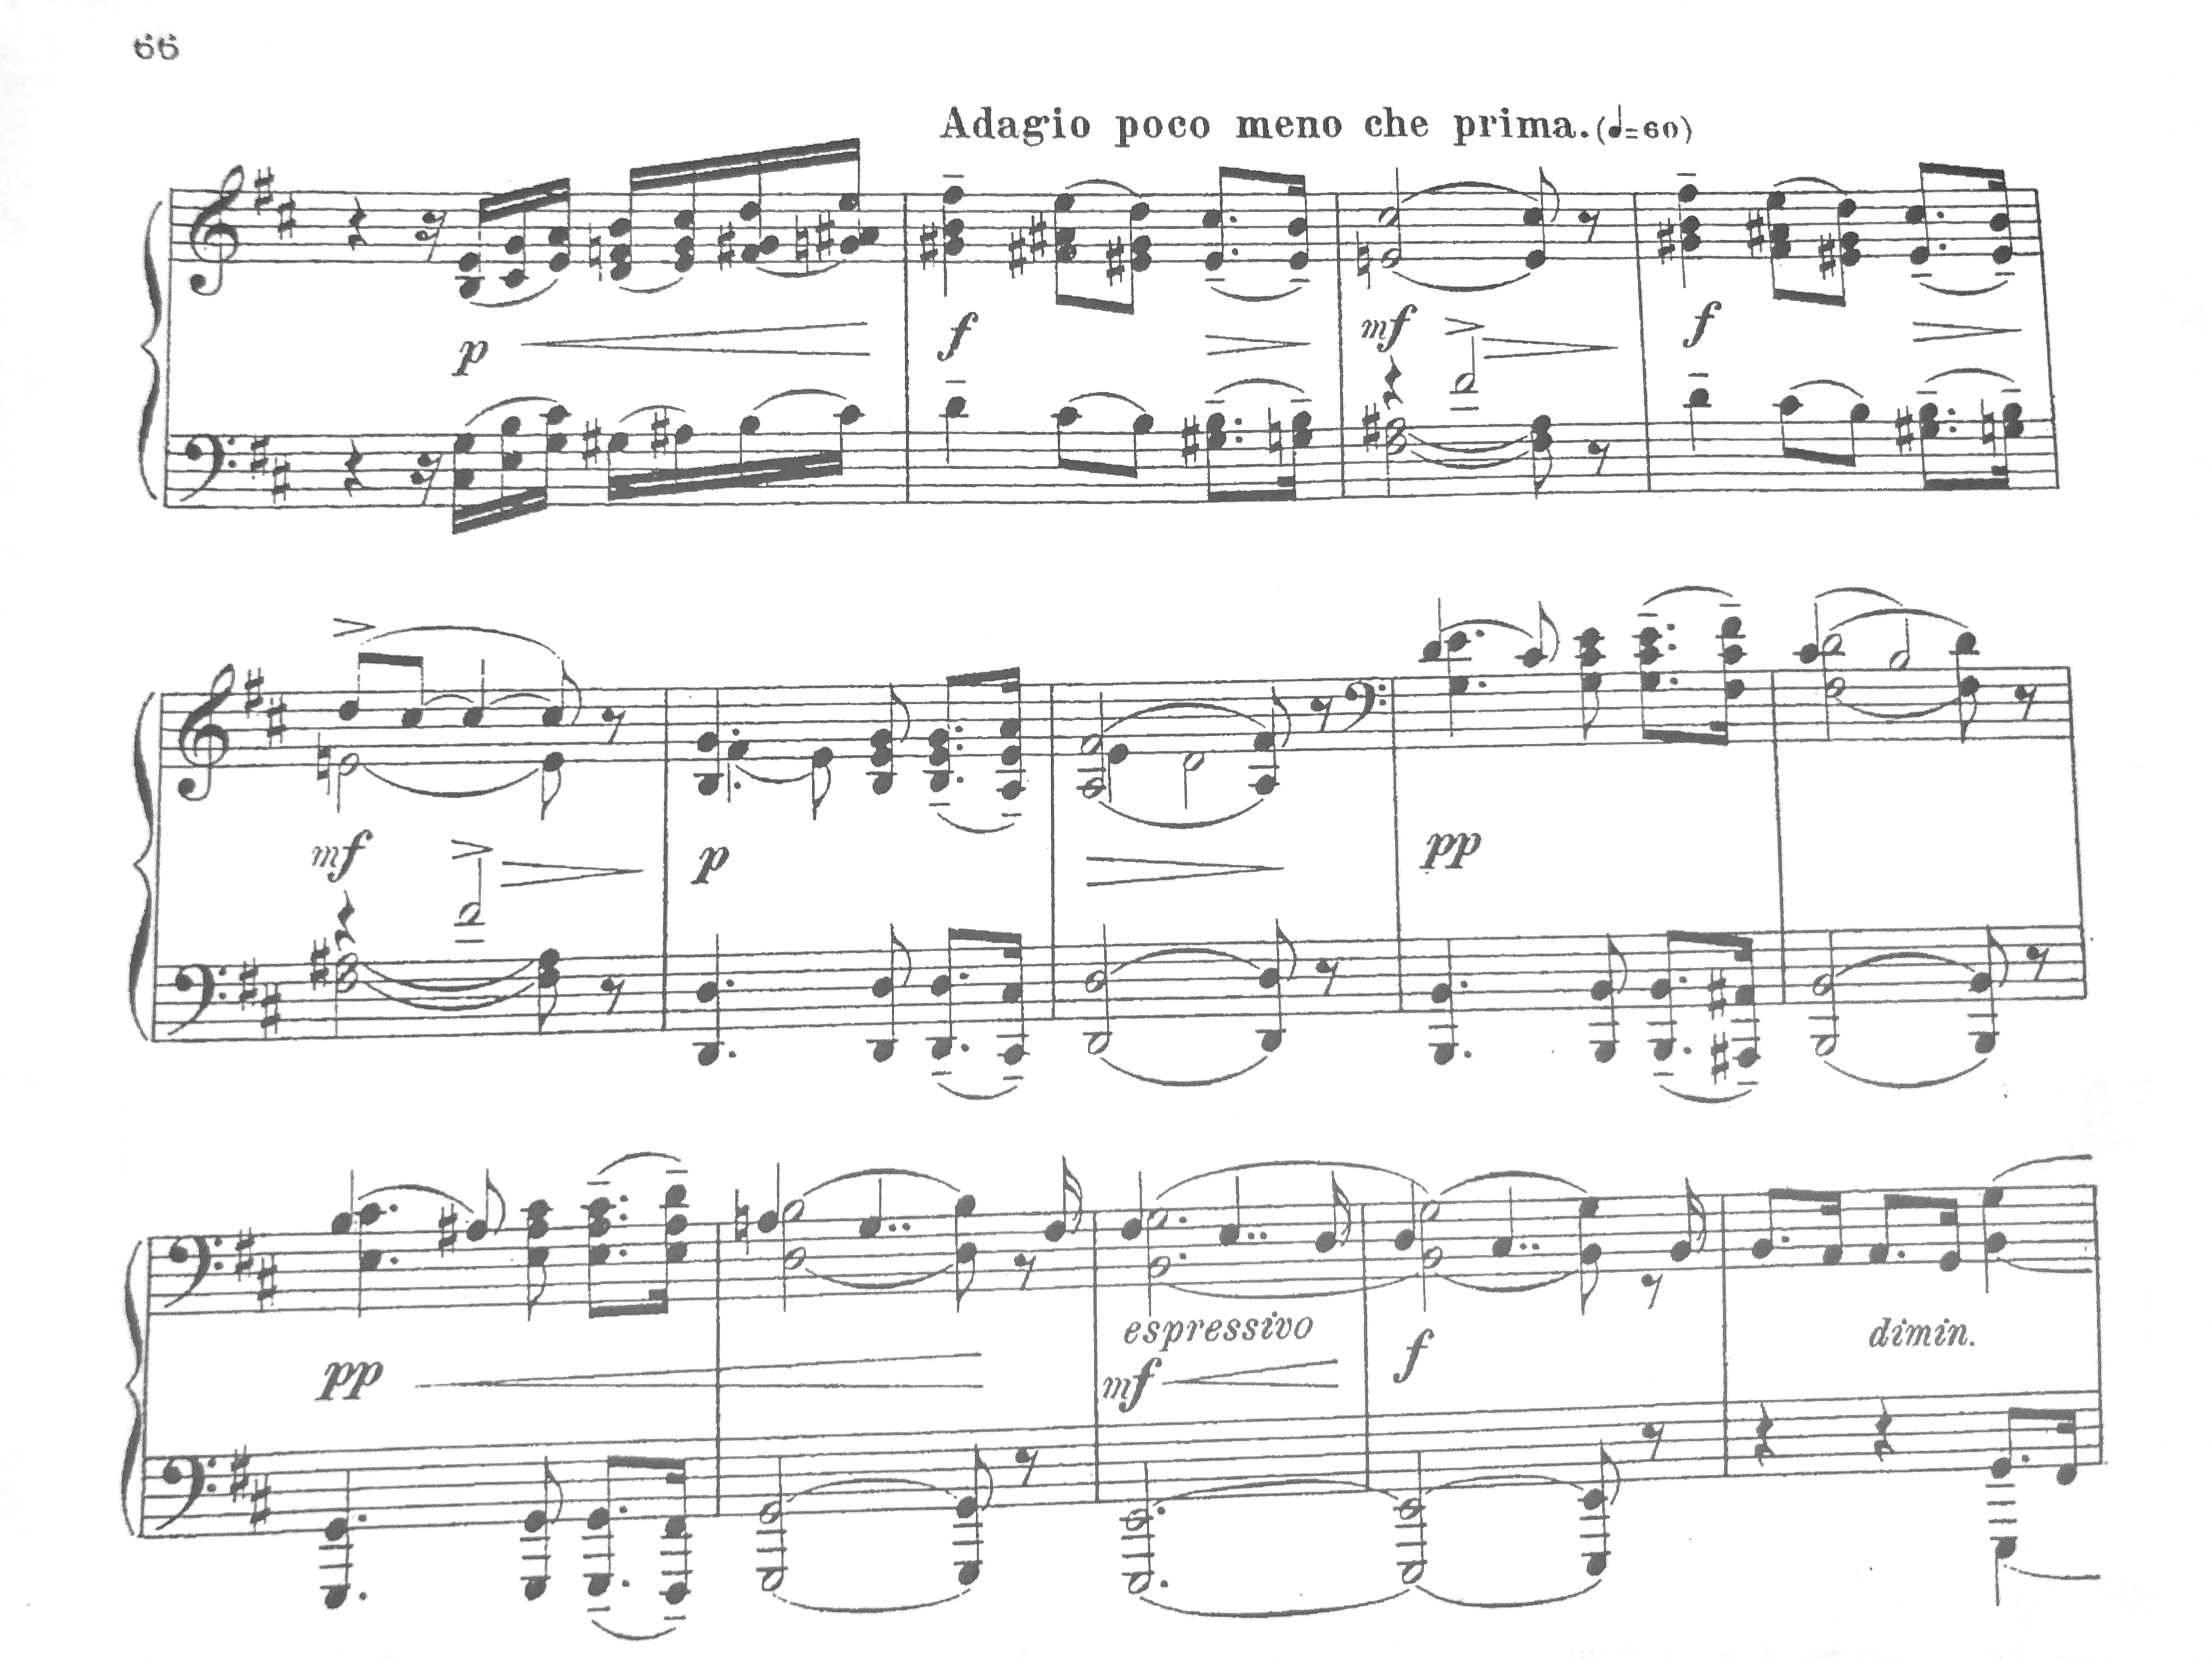

In [7]:
pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)
pim2

In [8]:
def getPenalizedCombFilter(linesep):
    filt = np.zeros(int(np.round(linesep * 5)))
    
    # positive spikes
    for i in range(5):
        offset = int(np.round(.5*linesep + i*linesep))
        filt[offset-1:offset+2] = 1.0
    
    # negative spikes
    for i in range(6):
        center = int(np.round(i*linesep))
        startIdx = max(center - 1, 0)
        endIdx = min(center + 2, len(filt))
        filt[startIdx:endIdx] = -1.0
        
    return filt

In [9]:
def estimateLineSep(pim, ncols, lrange, urange, delta):
    
    # break image into columns, calculate row medians for inner columns (exclude outermost columns)
    img = 255 - np.array(pim)
    imgHeight, imgWidth = img.shape
    rowMedians = np.zeros((imgHeight, ncols))
    colWidth = imgWidth // (ncols + 2)
    for i in range(ncols):
        rowMedians[:,i] = np.median(img[:,(i+1)*colWidth:(i+2)*colWidth], axis=1)
    
    # apply comb filters
    lineseps = np.arange(lrange, urange, delta)
    responses = np.zeros((len(lineseps), imgHeight, ncols))
    for i, linesep in enumerate(lineseps):
        filt = getPenalizedCombFilter(linesep).reshape((-1,1))
        responses[i,:,:] = convolve2d(rowMedians, filt, mode = 'same')
    
    # find comb filter with strongest response
    scores = np.sum(np.max(responses, axis=1), axis=1)
    bestIdx = np.argmax(scores)
    estLineSep = lineseps[bestIdx]
    
    return estLineSep, scores

In [10]:
# pim = pim2
# ncols = 3
# lrange = 25
# urange = 45
# delta = 1

In [11]:
# img = 255 - np.array(pim)
# imgHeight, imgWidth = img.shape
# rowMedians = np.zeros((imgHeight, ncols))
# colWidth = imgWidth // (ncols + 2)
# for i in range(ncols):
#     rowMedians[:,i] = np.median(img[:,(i+1)*colWidth:(i+2)*colWidth], axis=1)

# # apply comb filters
# lineseps = np.arange(lrange, urange, delta)
# responses = np.zeros((len(lineseps), imgHeight, ncols))
# for i, linesep in enumerate(lineseps):
#     filt = getPenalizedCombFilter(linesep).reshape((-1,1))
#     responses[i,:,:] = convolve2d(rowMedians, filt, mode = 'same')

# # find comb filter with strongest response
# scores = np.sum(np.max(responses, axis=1), axis=1)
# bestIdx = np.argmax(scores)
# estLineSep = lineseps[bestIdx]

In [12]:
linesep, scores = estimateLineSep(pim2, estLineSep_NumCols, estLineSep_LowerRange, estLineSep_UpperRange, estLineSep_Delta)
linesep

30

In [13]:
def calcResizedDimensions(pim, estimatedLineSep, desiredLineSep):
    curH, curW = pim.height, pim.width
    scale_factor = 1.0 * desiredLineSep / estimatedLineSep
    targetH = int(curH * scale_factor)
    targetW = int(curW * scale_factor)    
    return targetH, targetW

In [14]:
targetH, targetW = calcResizedDimensions(pim2, linesep, targetLineSep)
pim2 = pim2.resize((targetW, targetH))
targetH, targetW, pim1.height, pim1.width

(1008, 1344, 3024, 4032)

### Staff Line Features

In [15]:
def getNormImage(img):
    X = 1 - np.array(img) / 255.0
    return X

In [16]:
def showGrayscaleImage(X, sz = (10,10), maxval = 1, inverted = True):
    # by default assumes X is a normalized image between 0 (white) and 1 (black)
    plt.figure(figsize = sz)
    if inverted:
        plt.imshow(maxval-X, cmap='gray')
    else:
        plt.imshow(X, cmap='gray')

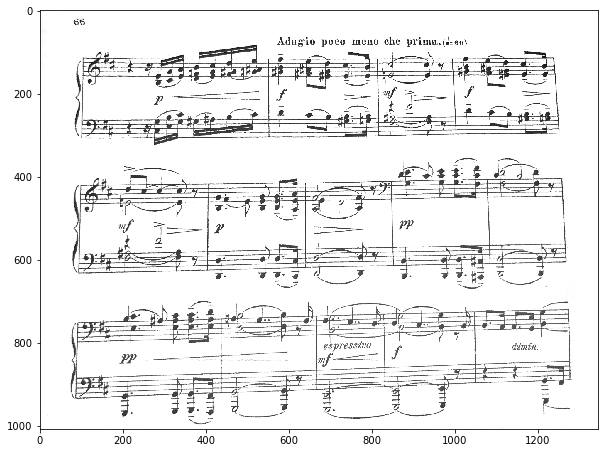

In [17]:
X2 = getNormImage(pim2)
showGrayscaleImage(X2)

In [18]:
# def morphFilterLinesHoriz(arr, kernel_len = 51):
#     kernel = np.ones((1,kernel_len),np.uint8)
#     hlines = cv2.erode(arr, kernel, iterations = 1)
#     hlines = cv2.dilate(hlines, kernel, iterations = 1)
#     return hlines

In [19]:
# def morphFilterLinesVert(arr, kernel_len = 51, dilate_width = 1):
#     vkernel = np.ones((kernel_len, 1), np.uint8)
#     lines = cv2.erode(arr, vkernel, iterations = 1)
#     lines = cv2.dilate(lines, vkernel, iterations = 1)
#     if dilate_width > 1:
#         hkernel = np.ones((1, dilate_width), np.uint8)
#         lines = cv2.dilate(lines, hkernel, iterations = 1)
#     return lines

In [20]:
def morphFilterRectangle(arr, kernel_height, kernel_width):
    kernel = np.ones((kernel_height, kernel_width),np.uint8)
    result = cv2.erode(arr, kernel, iterations = 1)
    result = cv2.dilate(result, kernel, iterations = 1)
    return result

In [21]:
def isolateStaffLines(arr, kernel_len, notebarfilt_len, notebar_removal):
    lines = morphFilterRectangle(arr, 1, kernel_len) # isolate horizontal lines
    notebarsOnly = morphFilterRectangle(lines, notebarfilt_len, 1) # isolate thick notebars
    result = np.clip(lines - notebar_removal*notebarsOnly, 0, None) # subtract out notebars
    return result

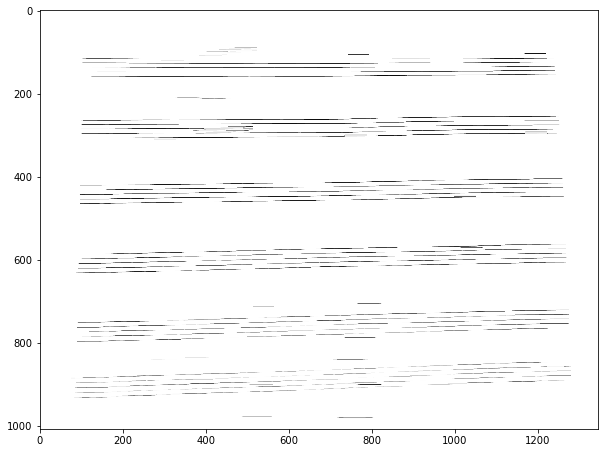

In [22]:
hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen, notebarRemoval)
showGrayscaleImage(hlines)

In [23]:
# def computeStaveFeatureMap(arr, combfilts, rowfiltlen):
#     featmap = []
#     rowfilt = np.ones((1, rowfiltlen))
#     for i in range(combfilts.shape[0]):
#         m = convolve2d(arr, np.fliplr(np.flipud(combfilts[i])), mode = 'valid')
#         m = convolve2d(m, rowfilt, mode = 'same')
#         featmap.append(m)
#     featmap = np.array(featmap)
#     return featmap

In [24]:
# combfilts, stavelens = createCombFilters(targetLineSep, combFilterSizeTol)
# featmap = computeStaveFeatureMap(hlines, combfilts, morphFilterHorizLineSize)

In [25]:
def getCombFilter(lineSep):
    # generate comb filter of specified length
    # e.g. if length is 44, then spikes at indices 0, 11, 22, 33, 44
    # e.g. if length is 43, then spikes at 0 [1.0], 10 [.25], 11 [.75], 21 [.5], 22 [.5], 32 [.75], 33 [.25], 43 [1.0]
    stavelen = int(np.ceil(4 * lineSep)) + 1
    combfilt = np.zeros(stavelen)
    for i in range(5):
        idx = i * lineSep
        idx_below = int(idx)
        idx_above = idx_below + 1
        remainder = idx - idx_below
        combfilt[idx_below] = 1 - remainder
        if idx_above < stavelen:
            combfilt[idx_above] = remainder
    return combfilt, stavelen

In [26]:
def computeStaveFeatureMap(img, ncols, lrange, urange, delta):
    
    # break image into columns, calculate row medians
    imgHeight, imgWidth = img.shape
    rowSums = np.zeros((imgHeight, ncols))
    colWidth = int(np.ceil(imgWidth/ncols))
    for i in range(ncols):
        startCol = i * colWidth
        endCol = min((i+1)*colWidth, imgWidth)
        rowSums[:,i] = np.sum(img[:,startCol:endCol], axis=1)
    
    # apply comb filters
    lineseps = np.arange(lrange, urange, delta)
    maxFiltSize = int(np.ceil(4 * lineseps[-1])) + 1
    featmap = np.zeros((len(lineseps), imgHeight - maxFiltSize + 1, ncols))
    stavelens = np.zeros(len(lineseps), dtype=np.int)
    for i, linesep in enumerate(lineseps):
        filt, stavelen = getCombFilter(linesep)
        padded = np.zeros((maxFiltSize, 1))
        padded[0:len(filt),:] = filt.reshape((-1,1))
        featmap[i,:,:] = convolve2d(rowSums, np.flipud(np.fliplr(padded)), mode = 'valid')
        stavelens[i] = stavelen
        
    return featmap, stavelens, colWidth

In [27]:
featmap, stavelens, columnWidth = computeStaveFeatureMap(hlines, calcStaveFeatureMap_NumCols, calcStaveFeatureMap_LowerRange, calcStaveFeatureMap_UpperRange, calcStaveFeatureMap_Delta)

### Notehead Detection

In [28]:
def morphFilterCircle(pimg, sz_reduce = 5, sz_expand = 0):
    kernel_reduce = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz_reduce, sz_reduce))
    result = cv2.dilate(np.array(pimg), kernel_reduce, iterations = 1)
    if sz_expand > 0:
        kernel_expand = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz_expand, sz_expand))
        result = cv2.erode(result, kernel_expand, iterations = 1)
    return result

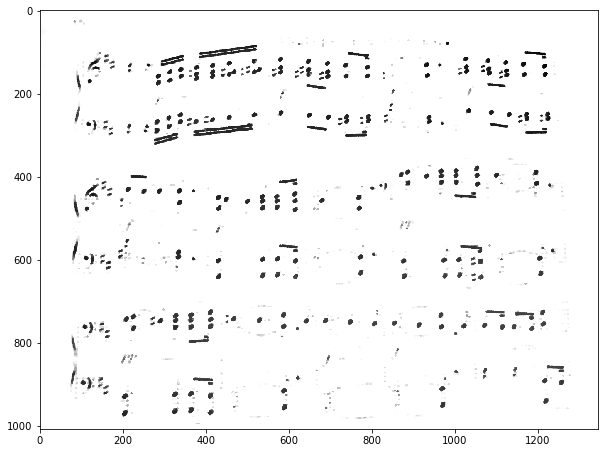

In [29]:
im3 = morphFilterCircle(pim2, morphFilterCircleSizeReduce, morphFilterCircleSizeExpand) # from here on use raw pixel values, not PIL image object
showGrayscaleImage(im3, maxval = 255, inverted = False)

In [30]:
def detectNoteheadBlobs(img, minarea, maxarea):
    
    # define blob detector
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    # params.minThreshold = 100;
    # params.maxThreshold = 200;

    # Filter by Area
    # params.filterByArea = True
    params.minArea = minarea
    params.maxArea = maxarea

    # Filter by Circularity
    # params.filterByCircularity = True
    # params.minCircularity = 0.1

    # Filter by Convexity
    # params.filterByConvexity = True
    # params.minConvexity = 0.87

    # Filter by Inertia
    # params.filterByInertia = True
    # params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    
    keypoints = detector.detect(img)
    im_with_keypoints = cv2.drawKeypoints(np.array(img), keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return keypoints, im_with_keypoints

In [31]:
def showColorImage(X, sz = (10,10)):
    plt.figure(figsize = sz)
    plt.imshow(X)

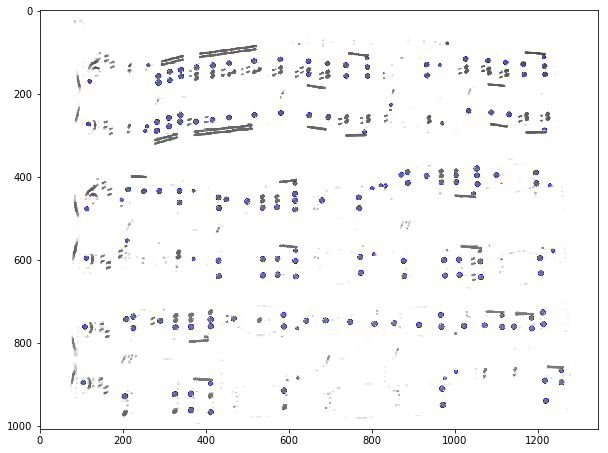

In [32]:
keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
showColorImage(im_with_keypoints)

In [33]:
def getNoteTemplate(arr, keypoints, sz = 21):
    template = np.zeros((sz,sz))
    L = (sz - 1)//2
    #crops = []
    numCrops = 0
    for k in keypoints:
        xloc = int(np.round(k.pt[0])) # col
        yloc = int(np.round(k.pt[1])) # row
        if xloc - L >= 0 and xloc + L + 1 <= arr.shape[1] and yloc - L >= 0 and yloc + L + 1 <= arr.shape[0]:
            crop = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
            #crops.append(crop)
            template += crop
            numCrops += 1
    if numCrops > 0:
        template = template / numCrops
    #template = template - np.mean(template.ravel()) # will be used as a filter, so make zero mean
    return template, numCrops

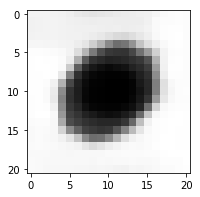

In [34]:
X3 = getNormImage(im3) # im indicates grayscale [0, 255], X indicates [0, 1] inverted grayscale
ntemplate, numCrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
showGrayscaleImage(ntemplate, (3,3), maxval = 1, inverted = True)

In [35]:
#np.sum(np.sum(binarize_otsu(ntemplate)[0]))

In [36]:
# def getRandomCrops(arr, N=200, sz=21):
#     crops = np.zeros((N,sz,sz))
#     L = (sz-1)//2
#     for i in range(N):
#         yloc = np.random.randint(L, arr.shape[0]-L) # row
#         xloc = np.random.randint(L, arr.shape[1]-L) # col
#         crops[i,:,:] = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
#     return crops

In [37]:
# def comparePosNegDistributions(pcrops, ncrops, template):
#     pos = []
#     for crop in pcrops:
#         pos.append(np.sum(crop * template))
#     neg = []
#     for crop in ncrops:
#         neg.append(np.sum(crop*template))
#     sns.kdeplot(np.array(pos))
#     sns.kdeplot(np.array(neg))
#     return pos, neg

In [38]:
# ncrops = getRandomCrops(X3)
# pos, neg = comparePosNegDistributions(pcrops, ncrops, ntemplate)

In [39]:
def adaptiveNoteheadDetect(arr, template, noteTolRatio, chordBlockSpecs):
    #filtered = convolve2d(arr, np.flipud(np.fliplr(template)), mode='same', boundary='symm')
    binarized, thresh = binarize_otsu(arr)
    templateSpecs = getNoteTemplateSpecs(template, thresh)
    labels = measure.label(binarized)
    notes = []
    for region in regionprops(labels):
        if isValidNotehead(region, noteTolRatio, templateSpecs):
            notes.append(region.bbox)
        elif isValidChordBlock(region, chordBlockSpecs, templateSpecs):
            chordNotes = extractNotesFromChordBlock(region, templateSpecs)
            notes.extend(chordNotes)
    return notes, binarized

In [40]:
def binarize_otsu(img):
    arr = np.array(img)
    thresh = filters.threshold_otsu(arr)
    binarized = arr > thresh
    return binarized, thresh

In [41]:
def getNoteTemplateSpecs(template, thresh):
    binarized = template > thresh
    labels = measure.label(binarized)
    maxH, maxW, maxArea = (0, 0, 0)
    for region in regionprops(labels):
        curH = region.bbox[2] - region.bbox[0]
        curW = region.bbox[3] - region.bbox[1]
        curArea = region.area
        if curArea > maxArea:
            maxArea = curArea
            maxH = curH
            maxW = curW
    return (maxH, maxW, maxArea)

In [42]:
def isValidNotehead(region, tol_ratio, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    max_ratio = 1 + tol_ratio
    min_ratio = 1 / (1 + tol_ratio)
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curRatio = 1.0 * curH / curW
    templateRatio = 1.0 * templateH / templateW
    validH = curH < templateH * max_ratio and curH > templateH * min_ratio
    validW = curW < templateW * max_ratio and curW > templateW * min_ratio
    validArea = curArea < templateArea * max_ratio * max_ratio and curArea > templateArea * min_ratio * min_ratio
    validRatio = curRatio < templateRatio * max_ratio and curRatio > templateRatio * min_ratio
    result = validH and validW and validRatio and validArea
    return result

In [43]:
def isValidChordBlock(region, params, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    minH, maxH, minW, maxW, minArea, maxArea, minNotes, maxNotes = params
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curNotes = int(np.round(curArea / templateArea))
    validH = curH >= minH * templateH and curH <= maxH * templateH
    validW = curW >= minW * templateW and curW <= maxW * templateW
    validArea = curArea >= minArea * templateArea and curArea <= maxArea * templateArea
    validNotes = curNotes >= minNotes and curNotes <= maxNotes
    result = validH and validW and validArea and validNotes
    return result

In [44]:
def extractNotesFromChordBlock(region, templateSpecs):
    # use kmeans to estimate note centers
    templateH, templateW, templateArea = templateSpecs
    numNotes = int(np.round(region.area / templateArea))
    regionCoords = np.array(region.coords)
    kmeans = KMeans(n_clusters=numNotes, n_init = 1).fit(regionCoords)
    bboxes = []
    for (r,c) in kmeans.cluster_centers_:
        rmin = int(np.round(r - templateH/2))
        rmax = int(np.round(r + templateH/2))
        cmin = int(np.round(c - templateW/2))
        cmax = int(np.round(c + templateW/2))
        bboxes.append((rmin, cmin, rmax, cmax))
    return bboxes

In [45]:
def visualizeLabels(img, bboxes):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    
    for (minr, minc, maxr, maxc) in bboxes:
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

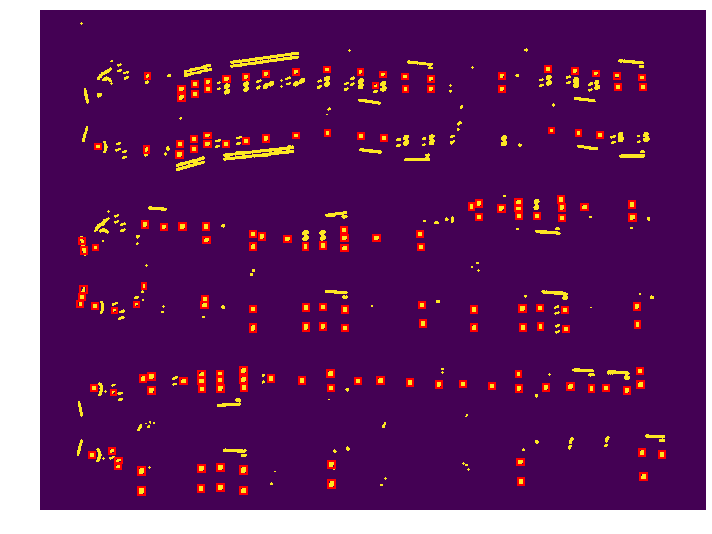

In [46]:
chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)
notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)
#showGrayscaleImage(img_binarized_notes)
visualizeLabels(img_binarized_notes, notes)

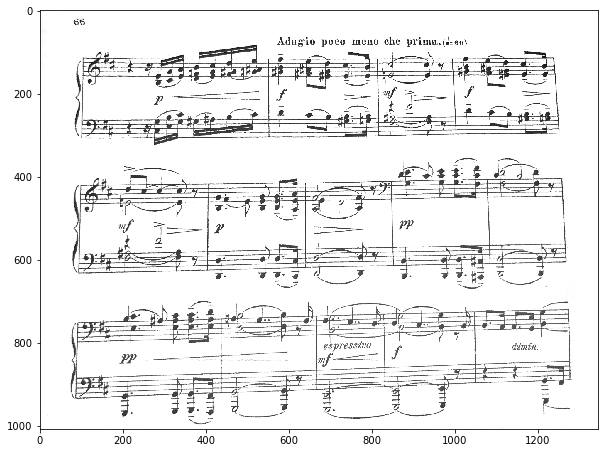

In [47]:
showGrayscaleImage(X2)

In [48]:
# def getContextRegion(arr, center, deltaR = 10, deltaC = 10):
#     r = int(np.round(center[0]))
#     c = int(np.round(center[1]))
#     rupper = min(r + deltaR + 1, arr.shape[0])
#     rlower = max(r - deltaR, 0)
#     cupper = min(c + deltaC + 1, arr.shape[1])
#     clower = max(c - deltaC, 0)
#     crop = arr[rlower:rupper,clower:cupper] 
#     return crop

In [49]:
# def getContextRegion2(arr, rstart, rend, cstart, cend):
#     rupper = min(rend, arr.shape[0])
#     rlower = max(rstart, 0)
#     cupper = min(cend, arr.shape[1])
#     clower = max(cstart, 0)
#     crop = arr[rlower:rupper,clower:cupper] 
#     return crop

In [50]:
def getNoteheadInfo(bboxes):
    nhlocs = [(.5*(bbox[0] + bbox[2]), .5*(bbox[1] + bbox[3])) for bbox in bboxes]
    nhlens = [(bbox[2] - bbox[0]) for bbox in bboxes]
    nhwidths = [(bbox[3] - bbox[1]) for bbox in bboxes]
    nhlen_est = int(np.ceil(np.mean(nhlens)))
    nhwidth_est = int(np.ceil(np.mean(nhwidths)))
    return nhlocs, nhlen_est, nhwidth_est

In [51]:
nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)
nhlen_est, nhwidth_est

(13, 13)

### Infer Note Values

In [52]:
def getEstStaffLineLocs(featmap, nhlocs, stavelens, colWidth, deltaRowMax, globalOffset = 0):
    preds = []
    if np.isscalar(globalOffset):
        globalOffset = [globalOffset] * len(nhlocs)
    for i, nhloc in enumerate(nhlocs):
        r = int(np.round(nhloc[0]))
        c = int(np.round(nhloc[1]))
        rupper = min(r + deltaRowMax + 1 + globalOffset[i], featmap.shape[1])
        rlower = max(r - deltaRowMax + globalOffset[i], 0)
        featmapIdx = c // colWidth
#         if featmapIdx == 0:
#             neighborIdx1 = 1
#             neighborIdx2 = 2
#         elif featmapIdx == featmap.shape[2] - 1:
#             neighborIdx1 = featmap.shape[2] - 3
#             neighborIdx2 = featmap.shape[2] - 2
#         else:
#             neighborIdx1 = featmapIdx - 1
#             neighborIdx2 = featmapIdx + 1
        regCurrent = np.squeeze(featmap[:, rlower:rupper, featmapIdx])
        #regNeighbor1 = np.squeeze(featmap[:, rlower:rupper, neighborIdx1])
        #regNeighbor2 = np.squeeze(featmap[:, rlower:rupper, neighborIdx2])
        mapidx, roffset = np.unravel_index(regCurrent.argmax(), regCurrent.shape)
        #mapidx_current, roffset_current = np.unravel_index(regCurrent.argmax(), regCurrent.shape)
        #mapidx_neighbor1, roffset_neighbor1 = np.unravel_index(regNeighbor1.argmax(), regNeighbor1.shape)
        #mapidx_neighbor2, roffset_neighbor2 = np.unravel_index(regNeighbor2.argmax(), regNeighbor2.shape)
        #mapidx = int(np.median([mapidx_current, mapidx_neighbor1, mapidx_neighbor2]))
        #roffset = np.median([roffset_current, roffset_neighbor1, roffset_neighbor2])
    
        rstart = rlower + roffset
        rend = rstart + stavelens[mapidx] - 1
        preds.append((rstart, rend, c, r, mapidx))
        
    sfiltlen = int(np.round(np.median([stavelens[tup[4]] for tup in preds])))
    return preds, sfiltlen

In [53]:
def visualizeEstStaffLines(preds, arr):
    showGrayscaleImage(arr, (15,15))
    rows1 = np.array([pred[0] for pred in preds]) # top staff line
    rows2 = np.array([pred[1] for pred in preds]) # bottom staff line
    cols = np.array([pred[2] for pred in preds]) # nh col
    rows3 = np.array([pred[3] for pred in preds]) # nh row
    plt.scatter(cols, rows1, c = 'r', s = 3)
    plt.scatter(cols, rows2, c = 'b', s = 3)
    plt.scatter(cols, rows3, c = 'y', s = 3)

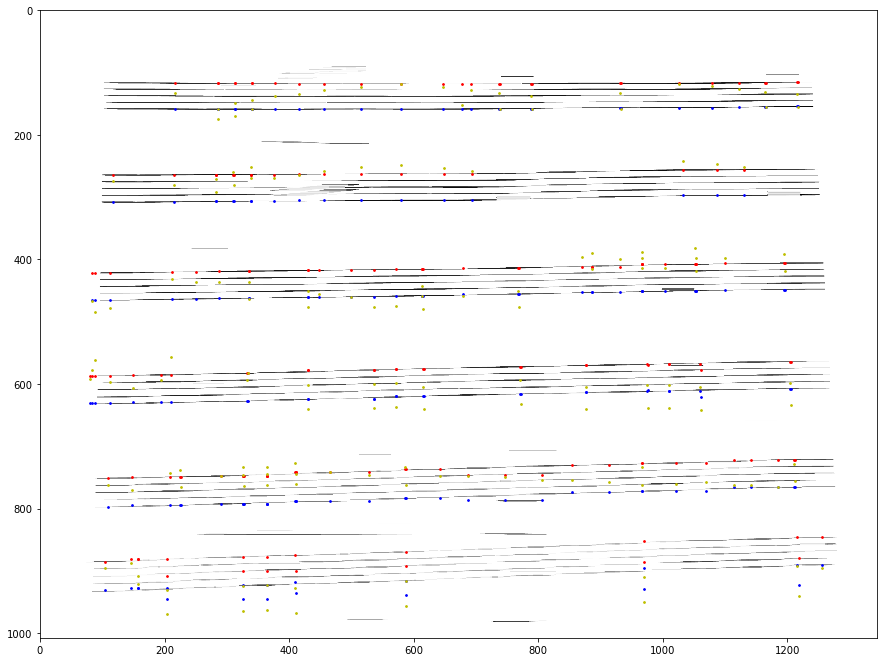

In [54]:
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowInitial, int(-2*targetLineSep))
visualizeEstStaffLines(estStaffLineLocs, hlines)

In [55]:
def estimateStaffMidpoints(preds, clustersMin, clustersMax, threshold):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    models = []
    for numClusters in range(clustersMin, clustersMax + 1):
        kmeans = KMeans(n_clusters=numClusters, n_init=1, random_state = 0).fit(r.reshape(-1,1))
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        mindiff = np.min(sorted_list[1:] - sorted_list[0:-1])
        if mindiff < threshold:
            break
        models.append(kmeans)
    staffMidpts = np.sort(np.squeeze(models[-1].cluster_centers_))
    return staffMidpts

In [56]:
def debugStaffMidpointClustering(preds):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    inertias = []
    mindiffs = []
    clusterRange = np.arange(2,12)
    for numClusters in clusterRange:
        kmeans = KMeans(n_clusters=numClusters, n_init=1).fit(r.reshape(-1,1))
        inertias.append(kmeans.inertia_)
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        diffs = sorted_list[1:] - sorted_list[0:-1]
        mindiffs.append(np.min(diffs))
    plt.subplot(211)
    plt.plot(clusterRange, np.log(inertias))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.subplot(212)
    plt.plot(clusterRange, mindiffs)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Min Centroid Separation')
    plt.axhline(60, color='r')

In [57]:
def visualizeStaffMidpointClustering(preds, centers):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    plt.plot(r, np.random.uniform(size = len(r)), '.')
    for center in centers:
        plt.axvline(x=center, color='r')

In [58]:
staveMidpts = estimateStaffMidpoints(estStaffLineLocs, minNumStaves, maxNumStaves, minStaveSeparation)

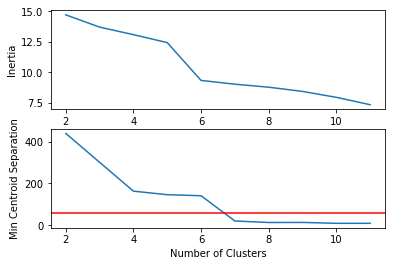

In [59]:
debugStaffMidpointClustering(estStaffLineLocs)

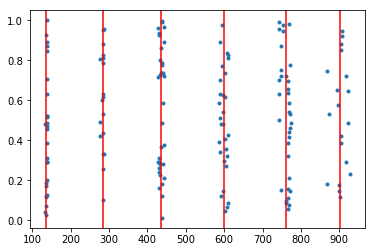

In [60]:
visualizeStaffMidpointClustering(estStaffLineLocs, staveMidpts)

In [61]:
def assignNoteheadsToStaves(nhlocs, staveCenters):
    nhrows = np.matlib.repmat([tup[0] for tup in nhlocs], len(staveCenters), 1)
    centers = np.matlib.repmat(staveCenters.reshape((-1,1)), 1, len(nhlocs))
    staveIdxs = np.argmin(np.abs(nhrows - centers), axis=0)
    offsets = staveCenters[staveIdxs] - nhrows[0,:] # row offset between note and staff midpoint
    return staveIdxs, offsets

In [62]:
def visualizeClusters(arr, nhlocs, clusters):
    showGrayscaleImage(arr)
    rows = np.array([tup[0] for tup in nhlocs])
    cols = np.array([tup[1] for tup in nhlocs])
    plt.scatter(cols, rows, c=clusters)
    for i in range(len(clusters)):
        plt.text(cols[i], rows[i] - 15, str(clusters[i]), fontsize = 12, color='red')

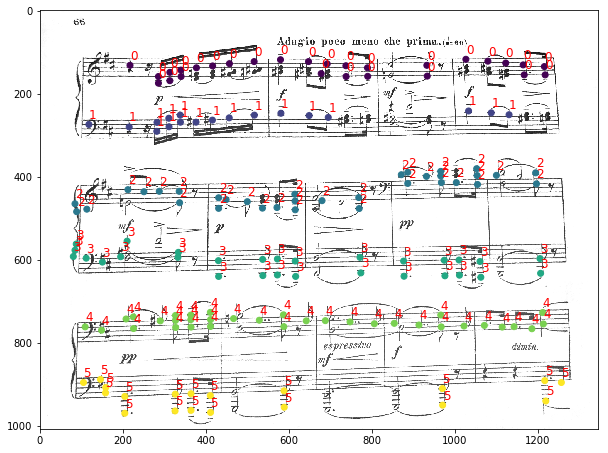

In [63]:
staveIdxs, nhRowOffsets = assignNoteheadsToStaves(nhlocs, staveMidpts)
visualizeClusters(X2, nhlocs, staveIdxs)

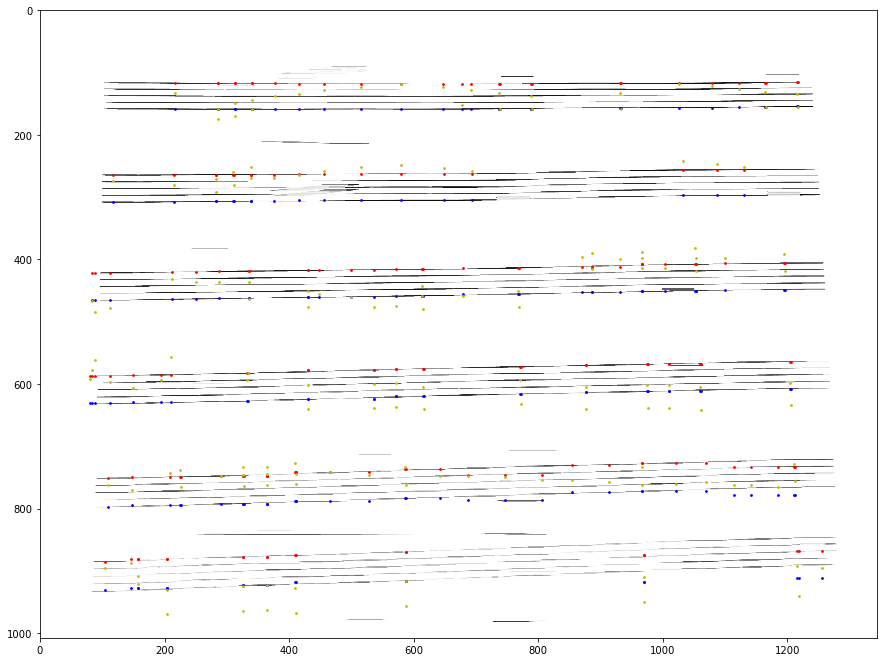

In [64]:
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowRefined, (nhRowOffsets - 2*targetLineSep).astype(np.int))
visualizeEstStaffLines(estStaffLineLocs, hlines)

In [65]:
# def getStaveTemplate(arr, preds, filtlen, rbuff = 0):
#     crops = np.zeros((len(preds), 2*rbuff + filtlen, 1))
#     for i, tup in enumerate(preds):
#         (rstart, rend, c, r, filtidx) = tup
#         reg = getContextRegion2(arr, rstart - rbuff, rstart + filtlen + rbuff, c, c + 1)
#         crops[i, 0:reg.shape[0], :] = reg
#     template = np.mean(crops, axis=0)
#     template = template - np.mean(template.ravel())
#     return template, crops

In [66]:
# stemplate, scrops = getStaveTemplate(hlines, estStaffLineLocs, sfiltlen)
# showGrayscaleImage(stemplate)
# sfiltlen

In [67]:
def estimateNoteLabels(preds):
    nhvals = [] # estimated note labels
    for i, (rstart, rend, c, r, filtidx) in enumerate(preds):       
        # if a stave has height L, there are 8 stave locations in (L-1) pixel rows
        staveMidpt = .5 * (rstart + rend)
        noteStaveLoc = -1.0 * (r - staveMidpt) * 8 / (rend - rstart)
        nhval = int(np.round(noteStaveLoc))
        nhvals.append(nhval)
    return nhvals

In [68]:
def visualizeNoteLabels(arr, vals, locs):
    showGrayscaleImage(arr)
    rows = np.array([loc[0] for loc in locs])
    cols = np.array([loc[1] for loc in locs])
    plt.scatter(cols, rows, color='blue')
    for i in range(len(rows)):
        plt.text(cols[i], rows[i] - 15, str(vals[i]), fontsize = 12, color='red')

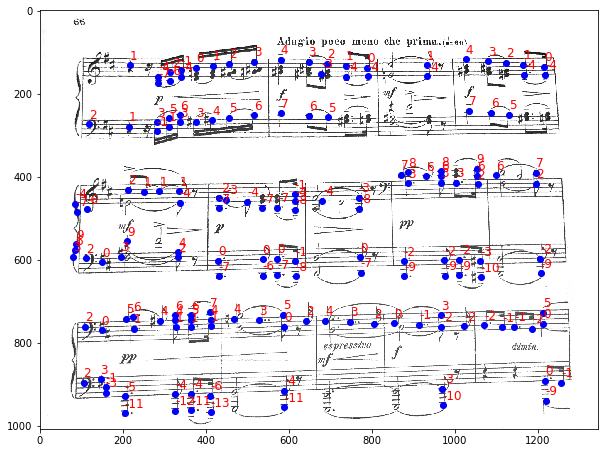

In [69]:
nhvals = estimateNoteLabels(estStaffLineLocs)
visualizeNoteLabels(X2, nhvals, nhlocs)

### Cluster staves & noteheads

In [70]:
def isolateBarlines(im, morphFilterVertLineLength, morphFilterVertLineWidth):
    hkernel = np.ones((1, morphFilterVertLineWidth), np.uint8) # dilate first to catch warped barlines
    vlines = cv2.dilate(im, hkernel, iterations = 1)
    vlines = morphFilterRectangle(vlines, morphFilterVertLineLength, 1) # then filter for tall vertical lines
    return vlines

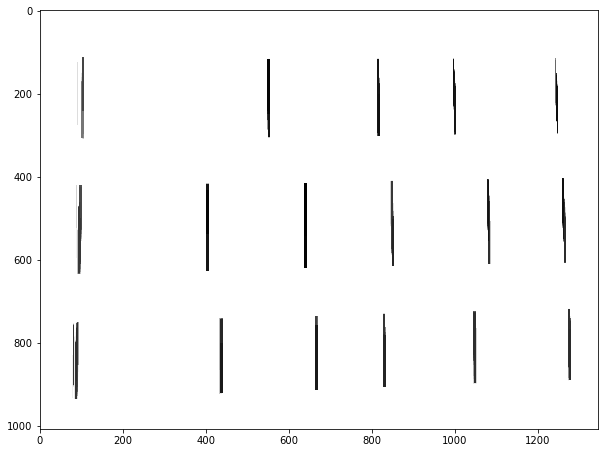

In [71]:
vlines = isolateBarlines(X2, morphFilterVertLineLength, morphFilterVertLineWidth)
showGrayscaleImage(vlines)

In [121]:
def determineStaveGrouping(staveMidpts, vlines):
    
    N = len(staveMidpts)
    rowSums = np.sum(vlines, axis=1)
    
    # grouping A: 0-1, 2-3, 4-5, ...
    elems_A = []
    map_A = {}
    for i, staveIdx in enumerate(np.arange(0, N, 2)):
        if staveIdx+1 < N:
            startRow = int(staveMidpts[staveIdx])
            endRow = int(staveMidpts[staveIdx+1]) + 1
            elems_A.extend(rowSums[startRow:endRow])
            map_A[staveIdx] = staveIdx
            map_A[staveIdx+1] = staveIdx + 1
        else:
            map_A[staveIdx] = -1 # unpaired stave
    
    # grouping B: 1-2, 3-4, 5-6, ...
    elems_B = []
    map_B = {}
    map_B[0] = -1 
    for i, staveIdx in enumerate(np.arange(1, N, 2)):
        if staveIdx+1 < N:
            startRow = int(staveMidpts[staveIdx])
            endRow = int(staveMidpts[staveIdx+1]) + 1
            elems_B.extend(rowSums[startRow:endRow])
            map_B[staveIdx] = staveIdx - 1
            map_B[staveIdx + 1] = staveIdx
        else:
            map_B[staveIdx] = -1
    
    evidence_A = np.mean(elems_A)
    evidence_B = np.mean(elems_B)
    if evidence_A > evidence_B:
        mapping = map_A
    else:
        mapping = map_B
    
    return mapping, (evidence_A, evidence_B, elems_A, elems_B)

In [73]:
staveMapping, evidence = determineStaveGrouping(staveMidpts, vlines)

In [74]:
def debugStaveGrouping(vlines, staveCenters):
    plt.plot(np.sum(vlines, axis=1))
    for m in staveCenters:
        plt.axvline(m, color = 'r')

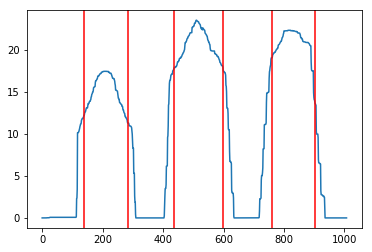

In [75]:
debugStaveGrouping(vlines, staveMidpts)

In [76]:
# def estimateBarlineThreshold(heights, maxVal):
#     pruned = np.array([h for h in heights if h < maxVal]) # toss out outliers (probably shadows)
#     if len(pruned) > 1:
#         thresh = filters.threshold_otsu(np.expand_dims(pruned, axis=0))
#     else:
#         thresh = 0
#     return thresh

In [77]:
# def isValidBarline(region, minBarlineLen, maxBarlineLen, maxBarlineWidth):
#     height = region.bbox[2] - region.bbox[0]
#     width = region.bbox[3] - region.bbox[1]
#     aboveMin = height > minBarlineLen
#     belowMaxLen = height < maxBarlineLen
#     belowMaxWidth = width < maxBarlineWidth
#     result = aboveMin and belowMaxLen and belowMaxWidth
#     return result

In [78]:
# def barlineDetect(arr, maxBarlineLen = 200, maxBarlineWidth = 10):
#     binarized, _ = binarize_otsu(arr)
#     labels = measure.label(binarized)
#     heights = [region.bbox[2] - region.bbox[0] for region in regionprops(labels)]
#     minBarlineLen = estimateBarlineThreshold(heights, maxBarlineLen)
#     bars = []
#     for region in regionprops(labels):
#         if isValidBarline(region, minBarlineLen, maxBarlineLen, maxBarlineWidth):
#             bars.append(region.bbox)
#     return bars, binarized

In [79]:
# maxBarlineLen = int(vlines.shape[0] * maxBarlineLenFactor)
# bars, img_binarized_bars = barlineDetect(vlines, maxBarlineLen, maxBarlineWidth)
# visualizeLabels(img_binarized_bars, bars)

In [80]:
# def calcOverlap(seg1, seg2):
#     lb = max(seg1[0], seg2[0])
#     ub = min(seg1[1], seg2[1])
#     overlap = np.clip(ub - lb, 0, None)
#     return overlap

In [81]:
# def clusterBarlines(bars):
    
#     # cluster overlapping barlines
#     clusters = -1*np.ones(len(bars), dtype=np.int8)
#     clusterIndex = 0
#     for i in range(len(bars)):
#         if clusters[i] == -1: # has not been assigned a cluster yet
#             anchor = (bars[i][0], bars[i][2])
#             for j in range(i,len(bars)):
#                 other = (bars[j][0], bars[j][2])
#                 overlap = calcOverlap(anchor, other)
#                 if overlap > 0:
#                     clusters[j] = clusterIndex
#             clusterIndex += 1
    
#     # determine bounds of each cluster
#     cluster_bnds = []
#     for i in range(clusterIndex):
#         selected = np.array([(reg[0], reg[2]) for j, reg in enumerate(bars) if clusters[j] == i])
#         lb = np.min(selected)
#         ub = np.max(selected)
#         cluster_bnds.append((lb, ub))
    
#     return clusters, cluster_bnds

In [82]:
# def visualizeBarClusters(arr, clusters):
#     showGrayscaleImage(arr, (5,5))
#     ax = plt.gca()
#     minc = 0
#     maxc = arr.shape[1] - 1
#     for (minr, maxr) in clusters:
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)
#     ax.set_axis_off()
#     plt.tight_layout()

In [83]:
# barline_clusters, barline_clusterbnds = clusterBarlines(bars)
# visualizeBarClusters(vlines, barline_clusterbnds)

In [84]:
def clusterNoteheads(staveIdxs, mapping):
    clusterIdxs = [mapping[staveIdx] for staveIdx in staveIdxs]
    maxClusterIdx = np.max(np.array(clusterIdxs))
    clusterPairs = []
    for i in range(0, maxClusterIdx, 2):
        clusterPairs.append((i,i+1))
    return clusterIdxs, clusterPairs

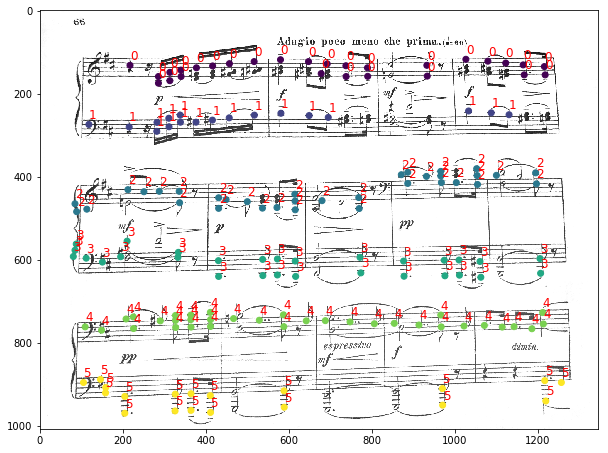

In [85]:
nhclusters, clusterPairs = clusterNoteheads(staveIdxs, staveMapping)
visualizeClusters(X2, nhlocs, nhclusters)

In [86]:
# def clusterNoteheads(midpts, barlines):
#     clusters = np.zeros(len(midpts), dtype=np.int8) # cluster index of each note
#     for i, midpt in enumerate(midpts):
#         clusteridx = -1 # -1 means notehead is not within a valid barline region
#         for j, (lb, ub) in enumerate(barlines):
#             if midpt >= lb and midpt <= ub:
#                 lb_dist = np.abs(midpt - lb)
#                 ub_dist = np.abs(midpt - ub)
#                 if lb_dist < ub_dist: # rh staff
#                     clusteridx = 2*j
#                 else:
#                     clusteridx = 2*j + 1 # lh staff
#                 break
#         clusters[i] = clusteridx     
#     return clusters

In [87]:
# def getClusterPairs(nhclusters, numLines):
#     # discard any "lines" that have no notes (may be a shadow)
#     validClusterIdxs = set(nhclusters)    
#     result = []
#     for i in range(0, 2*numLines, 2):
#         if i in validClusterIdxs or i+1 in validClusterIdxs:
#             result.append((i,i+1))
#     result = np.array(result)
#     return result

In [88]:
# nhclusters = clusterNoteheads(nhmidpts, barline_clusterbnds)
# clusterPairs = getClusterPairs(nhclusters, len(barline_clusterbnds))
# visualizeClusters(X2, estStaffLineLocs, nhclusters)

### Generate Bootleg Score

In [89]:
def generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes = 1, filler = 1):
    notes = [tup for tup in nhdata if tup[3] == clusterR or tup[3] == clusterL]
    notes = sorted(notes, key = lambda tup: (tup[1], tup[0])) # sort by column, then row
    collapsed = collapseSimultaneousEvents(notes, minColDiff) # list of (rows, cols, vals, clusters)
    bscore, eventIndices, staffLinesBoth, _, _ = constructBootlegScore(collapsed, clusterR, clusterL, repeatNotes, filler)
    return bscore, collapsed, eventIndices, staffLinesBoth

In [90]:
def collapseSimultaneousEvents(notes, minColDiff):
    assigned = np.zeros(len(notes), dtype=bool)
    events = [] # list of simultaneous note events
    for i, (row, col, val, cluster) in enumerate(notes):
        if assigned[i]: # has already been assigned
            continue
        rows = [row] # new event
        cols = [col]
        vals = [val]
        clusters = [cluster]
        assigned[i] = True
        for j in range(i+1, len(notes)):
            nrow, ncol, nval, ncluster = notes[j]
            if ncol - col < minColDiff: # assign to same event if close
                rows.append(nrow)
                cols.append(ncol)
                vals.append(nval)
                clusters.append(ncluster)
                assigned[j] = True
            else:
                break
        events.append((rows, cols, vals, clusters))
    
    assert(np.all(assigned))
    return events

In [91]:
def constructBootlegScore(noteEvents, clusterIndexRH, clusterIndexLH, repeatNotes = 1, filler = 1):
    # note that this has to match generateBootlegScore() in the previous notebook!
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    eventIndices = [] # index of corresponding simultaneous note event
    for i, (rows, cols, vals, clusters) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                eventIndices.append(i-1) # assign filler to previous event

        # insert note events columns
        rhvec, lhvec = getNoteheadPlacement(vals, clusters, rh_dim, lh_dim, clusterIndexRH, clusterIndexLH)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            eventIndices.append(i)
    rh = np.squeeze(np.array(rh)).reshape((-1, rh_dim)).T # reshape handles case when len(rh) == 1
    lh = np.squeeze(np.array(lh)).reshape((-1, lh_dim)).T
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, eventIndices, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [92]:
def getNoteheadPlacement(vals, clusters, rdim, ldim, clusterRH, clusterLH):
    rhvec = np.zeros((rdim, 1))
    lhvec = np.zeros((ldim, 1))
    assert(clusterLH == clusterRH + 1)
    for (val, cluster) in zip(vals, clusters):
        if cluster == clusterRH:
            idx = val + 11
            if idx >= 0 and idx < rdim:
                rhvec[idx, 0] = 1
        elif cluster == clusterLH:
            idx = val + 17
            if idx >= 0 and idx < ldim:
                lhvec[idx, 0] = 1
        else:
            print("Invalid cluster: {} (LH {}, RH {})".format(cluster, clusterLH, clusterRH))
            sys.exit(1)
    return rhvec, lhvec

In [93]:
def visualizeBootlegScore(bs, lines):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [94]:
# list of (row, col, value, cluster) tuples
nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]

In [95]:
#bscore, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR = 0, clusterL = 1, minColDiff = nhwidth_est, repeatNotes = 1, filler = 1)
#visualizeBootlegScore(bscore, staffLinesBoth)

In [96]:
def generateQueryBootlegScore(nhdata, pairings, repeatNotes = 1, filler = 1, minColDiff = 10):
    allScores = []
    allEvents = []
    globIndices = []
    eventCount = 0
    for i, (clusterR, clusterL) in enumerate(pairings):
        score, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes, filler)
        allScores.append(score)
        allEvents.extend(events)
        globIndices.extend([idx + eventCount for idx in eventIndices])
        if i < len(pairings) - 1:
            allScores.append(np.zeros((score.shape[0], filler))) # append filler columns between bootleg scores
            globIndices.extend([globIndices[-1]] * filler) # map filler columns to last event index
        eventCount += len(events)
    panorama = np.hstack(allScores)
    return panorama, allEvents, globIndices, staffLinesBoth

In [97]:
def visualizeLongBootlegScore(bs, lines, chunksz = 150):
    chunks = bs.shape[1] // chunksz + 1
    for i in range(chunks):
        startcol = i * chunksz
        endcol = min((i + 1)*chunksz, bs.shape[1])
        visualizeBootlegScore(bs[:,startcol:endcol], lines)

In [98]:
bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff = nhwidth_est)

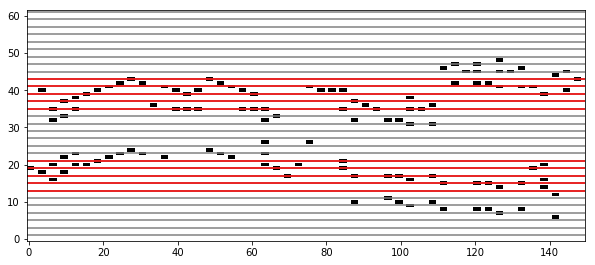

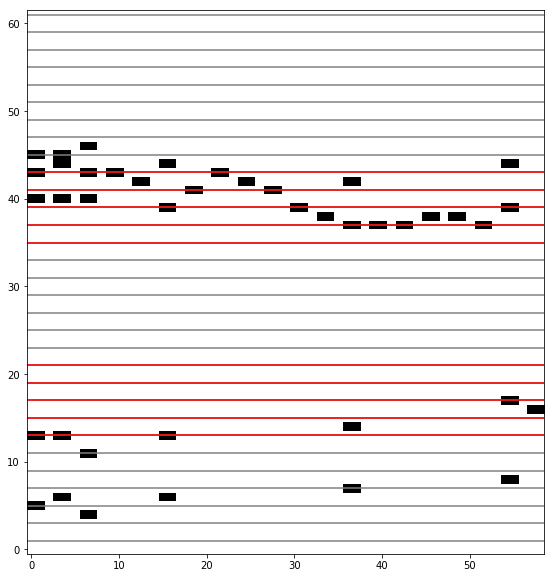

In [99]:
visualizeLongBootlegScore(bscore_query, staffLinesBoth)

### Align bootleg scores

In [100]:
def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    num_notes = np.array(d['num_notes'])
    stafflines = d['stafflines']
    return bscore, miditimes, num_notes, stafflines

In [101]:
def costMetric(X,Y):
    cost = -1 * np.dot(X,Y)
    return cost

In [102]:
def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    cost = -1 * np.matmul(Q.T, R)
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = cost / norm_factor
    return norm_cost

In [103]:
def alignBootlegScores(query, ref, numRefNotes, steps = [1,1,1,2,2,1], weights = [1,1,2], optimized=True):
    if optimized: # Cython implementation
        # set params
        assert len(steps) % 2 == 0, "The length of steps must be even."
        dn = np.array(steps[::2], dtype=np.uint32)
        dm = np.array(steps[1::2], dtype=np.uint32)
        dw = weights
        subsequence = True
        parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

        # Compute cost matrix
        #cost = costMetric(query.T, ref)
        numQueryNotes = np.sum(query, axis=0)
        cost = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)

        # DTW
        [D, s] = DTW_Cost_To_AccumCostAndSteps(cost, parameter)
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

        # Reformat the output
        wp = wp.T[::-1]
    else: # librosa implementation
        steps = np.array(steps).reshape((-1,2))
        D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

In [104]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [105]:
def plotAlignment(D, wp, seginfo = None):
    plt.figure(figsize = (10,10))
    plt.imshow(D, origin = 'lower', cmap = 'jet')
    plt.plot(wp[:,1], wp[:,0], color='y')
    plt.xlabel('Ref')
    plt.ylabel('Query')
    if seginfo is not None:
        matchSegTime, refSegTimes, refSegCols = seginfo
        for i, refSegCol in enumerate(refSegCols):            
            plt.axvline(refSegCol[0], color = 'm')
            plt.axvline(refSegCol[1], color = 'm')
        plt.title('Hyp ({:.1f} s, {:.1f} s), Ref ({:.1f} s, {:.1f} s)'.format(matchSegTime[0], matchSegTime[1], refSegTimes[0][0], refSegTimes[0][1]))
    else:
        plt.title('Subsequence DTW Alignment')

In [106]:
def getPredictedTimestamps(wp, times):
    start_frm_midi = wp[-1,1]
    end_frm_midi = wp[0,1]
    start_time_midi = times[start_frm_midi][0] # in sec
    end_time_midi = times[end_frm_midi][0]
    start_tick_midi = times[start_frm_midi][1] # in ticks
    end_tick_midi = times[end_frm_midi][1]
    return (start_time_midi, end_time_midi), (start_tick_midi, end_tick_midi)

In [107]:
def getGroundTruthTimestamps(imgfile, col2times):
    
    # get ground truth start, end times
    query = os.path.splitext(os.path.basename(imgfile))[0] # e.g. '/path/to/dir/p1_q10.jpg'
    query_gt_file = 'data/query_info/query.gt'
    refmatchesTime = []
    with open(query_gt_file, 'r') as f:
        for line in f:
            parts = line.rstrip().split(',')
            if parts[0] == query:
                tstart = float(parts[1])
                tend = float(parts[2])
                refmatchesTime.append((tstart, tend))
    
    # get start, end columns in bootleg score
    bscore_cols = np.arange(len(col2times))
    times = [tup[0] for tup in col2times]
    refmatchesCol = []
    for (tstart, tend) in refmatchesTime:
        col_start, col_end = np.interp([tstart, tend], times, bscore_cols)
        refmatchesCol.append((col_start, col_end))
    
    return refmatchesTime, refmatchesCol

In [108]:
pieceStr = os.path.basename(imagefile).split('_')[0]
midi_bscore_pkl = '{}/{}.pkl'.format(midi_db_dir, pieceStr)
bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)

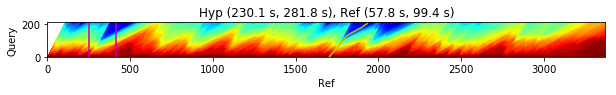

In [109]:
D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)
refSegmentTimes, refSegmentCols = getGroundTruthTimestamps(imagefile, miditimes)
plotAlignment(D, wp, (matchSegmentTime, refSegmentTimes, refSegmentCols))

In [110]:
def visualizeAlignedBScores(s1, s2, wp, lines):
    idxs1 = wp[::-1, 0]
    warped1 = s1[:,idxs1]
    idxs2 = wp[::-1, 1]
    warped2 = s2[:,idxs2]
    stacked = np.vstack((warped2, warped1))
    allLines = []
    allLines.extend(lines)
    allLines.extend(np.array(lines) + s1.shape[0])
    visualizeLongBootlegScore(stacked, allLines)

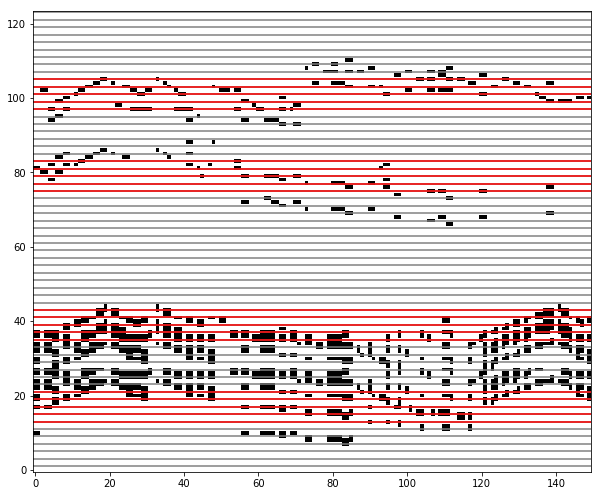

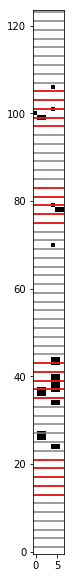

In [111]:
visualizeAlignedBScores(bscore_query, bscore_midi, wp, stafflines)

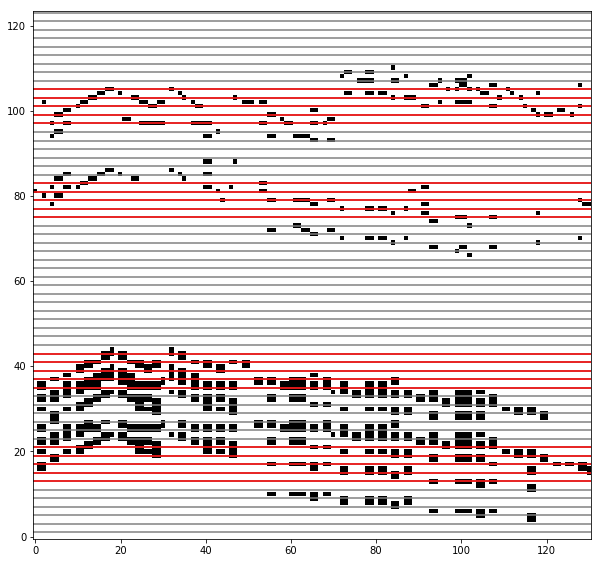

In [112]:
# visualize alignment between query and ground truth reference segment
refColStart = int(refSegmentCols[0][0])
refColEnd = int(refSegmentCols[0][1])
bscore_midi_refseg = bscore_midi[:,refColStart:refColEnd]
D2, wp2 = alignBootlegScores(bscore_query, bscore_midi_refseg, num_notes[refColStart:refColEnd])
visualizeAlignedBScores(bscore_query, bscore_midi_refseg, wp2, stafflines)

### Run system on all files

In [122]:
def processQuery(imagefile, midi_bscore_pkl, outfile = None):

    ### system parameters ###
    
    # Pre-processing
    #resizeW = 1000 # initial resize
    #resizeH = 1000
    thumbnailW = 100  # bkgd lighting
    thumbnailH = 100
    thumbnailFilterSize = 5
    estLineSep_NumCols = 3
    estLineSep_LowerRange = 25
    estLineSep_UpperRange = 45
    estLineSep_Delta = 1
    targetLineSep = 10.0

    # Staff Line Features
    morphFilterHorizLineSize = 51
    notebarFiltLen = 3
    notebarRemoval = 0.9
    calcStaveFeatureMap_NumCols = 10
    calcStaveFeatureMap_LowerRange = 8.5
    calcStaveFeatureMap_UpperRange = 11.75
    calcStaveFeatureMap_Delta = 0.25

    # Notehead Detection
    morphFilterCircleSizeReduce = 5
    morphFilterCircleSizeExpand = 5
    #morphFilterCircleSize = 5
    notedetect_minarea = 50
    notedetect_maxarea = 150 
    noteTemplateSize = 21
    notedetect_tol_ratio = .4
    chordBlock_minH = 1.8
    chordBlock_maxH = 4.25
    chordBlock_minW = .8
    chordBlock_maxW = 1.25
    chordBlock_minArea = 1.8
    chordBlock_maxArea = 4.5
    chordBlock_minNotes = 2
    chordBlock_maxNotes = 4

    # Staffline Detection
    maxDeltaRowInitial = 50
    minNumStaves = 2
    maxNumStaves = 12
    minStaveSeparation = 6 * targetLineSep
    maxDeltaRowRefined = 15

    # Group Staves
    morphFilterVertLineLength = 101
    morphFilterVertLineWidth = 7
    #maxBarlineLenFactor = .25
    #maxBarlineWidth = 10

    # Generate Bootleg Score
    bootlegRepeatNotes = 2 
    bootlegFiller = 1

    # Alignment
    dtw_steps = [1,1,1,2,2,1] # dtw
    dtw_weights = [1,1,2]

    ##########################
    
    print("Processing {}".format(imagefile))
    profileStart = time.time()

    # pre-processing
    pim1 = Image.open(imagefile).convert('L') # pim indicates PIL image object, im indicates raw pixel values
    #pim1 = pim1.resize([resizeW, resizeH])
    pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)
    linesep, scores = estimateLineSep(pim2, estLineSep_NumCols, estLineSep_LowerRange, estLineSep_UpperRange, estLineSep_Delta)
    targetH, targetW = calcResizedDimensions(pim2, linesep, targetLineSep)
    pim2 = pim2.resize((targetW, targetH))

    # staff line features
    X2 = getNormImage(pim2)
    hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen, notebarRemoval)
    featmap, stavelens, columnWidth = computeStaveFeatureMap(hlines, calcStaveFeatureMap_NumCols, calcStaveFeatureMap_LowerRange, calcStaveFeatureMap_UpperRange, calcStaveFeatureMap_Delta)
    
    # notehead detection
    im3 = morphFilterCircle(pim2, morphFilterCircleSizeReduce, morphFilterCircleSizeExpand)
    keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
    X3 = getNormImage(im3) # im indicates grayscale [0, 255], X indicates [0, 1] inverted grayscale
    ntemplate, numCrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
    chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)
    notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)
    if len(notes) == 0: # if no notes detected, stop early
        saveToFile(outfile, imagefile, (0, 0), time.time() - profileStart)
        return (0,0)
    nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)
    
    # infer note values
    estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowInitial, int(-2*targetLineSep))
    staveMidpts = estimateStaffMidpoints(estStaffLineLocs, minNumStaves, maxNumStaves, minStaveSeparation)
    staveIdxs, nhRowOffsets = assignNoteheadsToStaves(nhlocs, staveMidpts)
    estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowRefined, (nhRowOffsets - 2*targetLineSep).astype(np.int))    
    nhvals = estimateNoteLabels(estStaffLineLocs)
    
    # cluster noteheads & staves
    vlines = isolateBarlines(X2, morphFilterVertLineLength, morphFilterVertLineWidth)
    staveMapping, evidence = determineStaveGrouping(staveMidpts, vlines)
    nhclusters, clusterPairs = clusterNoteheads(staveIdxs, staveMapping)
    
    # generate & align bootleg scores
    nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]
    bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff = nhwidth_est)
    bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
    D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
    matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)
        
    # profile & save to file
    profileEnd = time.time()
    profileDur = profileEnd - profileStart
    saveToFile(outfile, imagefile, matchSegmentTime, profileDur)
        
    return matchSegmentTime

In [114]:
def saveToFile(outfile, imagefile, segment, dur):
    if outfile:
        with open(outfile, 'w') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            outStr = "{},{:.2f},{:.2f},{:.2f}\n".format(query, segment[0], segment[1], dur)
            f.write(outStr)

In [115]:
# # # process single query
# query_file = 'data/queries/p1_q1.jpg'
# pieceStr = os.path.basename(query_file).split('_')[0]
# midi_bscore_file = 'experiments/baseline/db/{}.pkl'.format(pieceStr)
# matchTimes = processQuery(query_file, midi_bscore_file)
# matchTimes
# #cProfile.run("processQuery(query_file, midi_bscore_file)") # for profiling

In [116]:
def processQuery_wrapper(queryfile, mididir, outdir):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    piece = basename.split('_')[0]
    midiBootlegFile = "{}/{}.pkl".format(mididir, piece)
    return processQuery(queryfile, midiBootlegFile, hyp_outfile)

In [123]:
# process all queries
query_list = 'cfg_files/query.train.list' # list of query images
midi_bs_dir = 'experiments/baseline/db' # directory containing midi bootleg scores
outdir = 'experiments/baseline/hyp' # where to save hypothesis output files

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# number of cores to use
n_cores = 32 #multiprocessing.cpu_count()

# prep inputs for parallelization
inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), midi_bs_dir, outdir))

# process queries in parallel
pool = multiprocessing.Pool(processes=n_cores)
outputs = list(pool.starmap(processQuery_wrapper, inputs))

Processing data/queries/p11_q1.jpg
Processing data/queries/p11_q10.jpg
Processing data/queries/p11_q3.jpg
Processing data/queries/p11_q2.jpg
Processing data/queries/p11_q5.jpg
Processing data/queries/p11_q8.jpg
Processing data/queries/p11_q9.jpg
Processing data/queries/p11_q7.jpg
Processing data/queries/p1_q1.jpg
Processing data/queries/p11_q4.jpg
Processing data/queries/p1_q10.jpg
Processing data/queries/p1_q6.jpg
Processing data/queries/p11_q6.jpg
Processing data/queries/p1_q8.jpg
Processing data/queries/p1_q2.jpg
Processing data/queries/p1_q5.jpg
Processing data/queries/p1_q4.jpg
Processing data/queries/p1_q3.jpg
Processing data/queries/p1_q7.jpg
Processing data/queries/p21_q4.jpg
Processing data/queries/p21_q1.jpg
Processing data/queries/p1_q9.jpg
Processing data/queries/p21_q2.jpg
Processing data/queries/p21_q3.jpg
Processing data/queries/p21_q7.jpg
Processing data/queries/p21_q5.jpg
Processing data/queries/p21_q10.jpg
Processing data/queries/p21_q6.jpg
Processing data/queries/p21